In [1]:
import os
os.getpid()

31606

In [2]:
import json
f = open('ESConv.json')
data = json.load(f)
f.close()
processed_data = []
for i in data:
    pt = i['problem_type']
    for j in i['dialog']:
        processed_data.append((pt, j['content']))
sl = []
for i in processed_data:
    sl.append(len(i[1].split()))
## Safely, we remove length 1,2,3
to_remove = []
for i in range(len(sl)):
    if sl[i] <= 3:
        to_remove.append(i)

for index in sorted(to_remove, reverse=True):
    del processed_data[index]
# For now, we only care the first 5 categories.
kept = ['problems with friends', 'ongoing depression','breakup with partner', 'academic pressure', 'job crisis' ]
filtered_processed_data = []
for i in processed_data:
    if i[0] in kept:
        filtered_processed_data.append(list(i))
        filtered_processed_data[-1][0] = kept.index(filtered_processed_data[-1][0])
import random
random.seed(10)
random.shuffle(filtered_processed_data)
lenth = len(filtered_processed_data)
train_list = filtered_processed_data[0:int(lenth*0.8)]
test_list = filtered_processed_data[int(lenth*0.8):]
from collections import Counter
# Count labels in testing
lts = []
for i in test_list:
    lts.append(i[0])
Counter(lts)

Counter({2: 1286, 4: 1488, 1: 1889, 0: 962, 3: 844})

In [3]:
list4 = []
for i in filtered_processed_data:
    list4.extend(i[1].split(" "))
print(list4[0])

from collections import Counter
import re

c = Counter(list4)

I


In [4]:
c.most_common(20000)

[('I', 23526),
 ('to', 20333),
 ('you', 17098),
 ('a', 12472),
 ('and', 11657),
 ('the', 10956),
 ('', 10171),
 ('that', 8320),
 ('is', 7370),
 ('have', 6539),
 ('of', 6537),
 ('for', 6201),
 ('it', 5863),
 ('are', 5612),
 ('my', 5371),
 ('your', 5110),
 ('in', 5007),
 ('with', 4718),
 ('be', 4468),
 ('can', 4267),
 ('but', 3834),
 ('not', 3686),
 ('do', 3615),
 ('i', 3409),
 ('am', 3367),
 ('like', 3260),
 ('me', 3148),
 ('about', 3067),
 ('so', 3014),
 ('on', 2878),
 ('just', 2835),
 ('this', 2793),
 ('will', 2792),
 ('feel', 2695),
 ('think', 2648),
 ('was', 2225),
 ('get', 2202),
 ("I'm", 2171),
 ('been', 2107),
 ('how', 2107),
 ('as', 2038),
 ('or', 2018),
 ('at', 2009),
 ('help', 2008),
 ('really', 1998),
 ('know', 1984),
 ('what', 1942),
 ('\n', 1937),
 ('if', 1909),
 ('good', 1909),
 ('would', 1902),
 ('out', 1901),
 ('It', 1828),
 ('time', 1757),
 ('they', 1745),
 ("don't", 1653),
 ('very', 1635),
 ('he', 1626),
 ('all', 1607),
 ('there', 1601),
 ('some', 1596),
 ('we', 1491),

In [5]:
# NB: In this version,
# WE ONLY embed for frequent words.
# Other words are all converterted to "N0O0N"
selected = c.most_common(20000)
selected_index_word = []
for i in selected:
    selected_index_word.append(i[0])
selected_index_word[-1]

'connected?'

## We are only considering the 20000 most common words
## We convert all other words to N0O0N, which indicate unknown words.

In [6]:
# convert to N0O0N
def convert(word_list):
    for i, v in enumerate(word_list):
        if v not in selected_index_word:
            word_list[i] = "N0O0N"
    return word_list

In [7]:
import numpy as np

import torch
from torch.utils.data.sampler import BatchSampler, Sampler
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

import random
from tqdm import tqdm

SEED=4321
random.seed(SEED)
np.random.seed(SEED)


class Corpora():
    """
    The class holds training and test corpora.
    """

    def __init__(self):
        """
        Constructor
        """
        # word to index (1-based integers) mapping
        self.word_index = {"N0O0N":0}
        self.index_word = ["N0O0N"]
        # list of reviews tuples, each of which is (sentence_list, rate),
        self.training_reviews = []
        # (sentence_list, rate) Same format as training_sentences
        self.test_reviews = []

        self.max_len = 0


    # input: a tuple (reviewList, rate)
    # todo: insert values into fields
    # Return the list representing all index of words in a review.
    def insert_fields(self, input):   
        # Sentence list
        word_indexes = []
        for word in input:
            if word not in self.word_index.keys():
                self.word_index.update({word:len(self.word_index.keys())}) #No add 1 because 0 is already in
                self.index_word.append(word)
            # find the index of this word, add to return list
            word_indexes.append(self.word_index[word])
        if len(word_indexes)>self.max_len:
            self.max_len = len(word_indexes)
        return word_indexes
    
    
    
    
    # Different than P2, here we 
    def read_corpus(self, is_training):
        if is_training is True:
            target = train_list
        else:
            target = test_list
        print("reading corpus ...")
        for rate, text in tqdm(target):
            input = text.split(" ")
            input = convert(input)
            tuple = (self.insert_fields(input), rate)
            if is_training: 
                self.training_reviews.append(tuple)
            else:
                self.test_reviews.append(tuple)
                    
                
# Inherient Dataset, convert list and int to tensors, load to GPU.
class ReviewRateDataset(Dataset):
   
    def __init__(self, review_rate_pairs): # NB: sequence_pairs is corpora.training_reviews, 
        # list of (sentence_list, rate)
        self.review_rate_pairs = review_rate_pairs

    def __len__(self):
        return len(self.review_rate_pairs)

    def __getitem__(self, idx):
        sentence_list, rate = self.review_rate_pairs[idx] 
        return torch.tensor(sentence_list), torch.tensor(int(rate))

# NB! This class will be in DataLoader function as a parameter for batch_sampler
class SortedBatchSampler(Sampler):
    """
        Each sequence in a mini-batch must of the same lengths, while our sentences
        are of various lengths.
        We can pad the sentences to the same lengths in each mini-batch.
        But if a short and long sentences are in the same mini-batch, more paddings
        are needed.
        We sort the sentences based on their lengths (in descending order)
            and then put sentences with similar lengths in a batch to reduce the paddings.
    """
    def __init__(self, dataset, batch_size):
        """
            dataset: an torch.utils.data.DataSet object containing all training sequences
            batch_size: the number of sequences to put in a mini-batch
        """

        # The sorting and batching go within this function.      
        self.batch_size = batch_size 
        # Sort the dataset (Based on the length of sentence.)
        dataset.review_rate_pairs  = sorted(dataset.review_rate_pairs,key=lambda x:len(x[0]), reverse=True)
        self.sorted_lengths = len(dataset)
        # Batching: Split the dataset into a list of datasets
        self.index_batches = []  
        # -- NB: Collate function does not work, so I pad it directly.
        for i in range(self.__len__()):
            self.index_batches.append(padding_collate_func(ReviewRateDataset(dataset.review_rate_pairs[i*batch_size:i*batch_size+batch_size])))
        # Now, each mini-batches is a ReviewRateDataset object
        # If else format is needed, may change it latter.
        
        
    def __iter__(self):
        """
            return a Python iterator object that iterates the mini-batchs of
                training data indices (not individual indices)
        """
        return iter(self.index_batches)

    def __len__(self):
        return self.sorted_lengths // self.batch_size

# NB! This function will be in DataLoader function as a parameter for collate_fn
def padding_collate_func(batch):
    """
        Transform pairs of input-output sequences in the batch to be of the same length using the function
            torch.nn.utils.rnn.pad_sequence.
        batch: An iterator and each element is a pair of (input_sequence, output_sequence).
        For POS tagging, len(input_sequence) = len(output_sequence). But for different
        pairs in batch, their lengths can differ.

        Example: a batch of 3 pairs of input/output sequences
                [([1,2,3],[1,1,1]), ([1,2,3,4],[2,2,2,2]), ([1,2,3,4,5],[3,3,3,3,3])]
                Note: [] encloses tensors (not numpy arra ys)
                
                
                !!!!!NB QUESTION:  it is the inner [] that encloses tensors, right?
                Comment: Batch is an element of a Sampler (see test_p1.py, a l[0] is a batch)
                
                
        return: two tensors (one for input sequence batch and another for output sequence batch).
                These tensors are padded with zeros so that all sequences in the same batch
                are of the same length.
        Example: input_sequence_batch = [[1,2,3,0,0], [1,2,3,4,0], [1,2,3,4,5]],
                 output_sequence_batch = [[1,1,1,0,0], [2,2,2,2,0], [3,3,3,3,3]]

    """
    ### Your codes go here (5 points) ###
    # Hint: read the article linked at the top of this cell.
    
    # NOTe
    # len(batch[0][0]) == len(batch.sequence_pairs[0]) == the target value (the maximum length for each batch)
    # I fill it might be easier to pad sequence_pairs with tuple (0,0), but let's see.
    
    # Doubles the memory takes by this batch, which is not good
    new_l = []
    rate = []
    for i,j in batch.review_rate_pairs:
        new_l.append( torch.tensor(i))
        rate.append( torch.tensor(int(j)))
    padded = pad_sequence(new_l, batch_first=True, padding_value=0)
    #print("len ", len(padded), len(rate)) #BUG: NEED ZIP HERE
    obj = ReviewRateDataset(list(zip(padded,rate)))
    # NB: For now the outter [] is neither tensor nor list, it is an obj!
    # Change latter if necessary
    # Yes, let's change it to two tensors return
    ret1 = []
    ret2 = []
    for i in obj:
        ret1.append(i[0])
        ret2.append(i[1])
    ret1 = torch.stack(ret1)
    ret2 = torch.stack(ret2)
    return ret1, ret2

# Load Corpora, Get DataLoader Ready

In [8]:
# NB: DO NOT RE-RUN THIS CELL
# NB: DO NOT RE-RUN THIS CELL
# NB: DO NOT RE-RUN THIS CELL
# NB: DO NOT RE-RUN THIS CELL
# NB: DO NOT RE-RUN THIS CELL
# NB: DO NOT RE-RUN THIS CELL

#
#
from torch import optim
import time
import math

BATCH_SIZE = 64


corpora = Corpora()

corpora.read_corpus(True)
corpora.read_corpus(False)

print(f'Number of training sentences = {len(corpora.training_reviews)}')
print(f'Number of test sentences = {len(corpora.test_reviews)}')
print(f'Number of unique input tokens = {len(corpora.word_index)}')
print(f'Maximal sentence length = {corpora.max_len}')

print("\n\n Creating training Dataset, Sampler, and Iterators...")
training_dataset = ReviewRateDataset(corpora.training_reviews)
training_sampler = SortedBatchSampler(training_dataset, batch_size=BATCH_SIZE)
training_iterator = DataLoader(training_dataset,
                                  collate_fn = padding_collate_func,
                                  batch_sampler = training_sampler)
print("\n\n Creating test Dataset, Sampler, and Iterators")
test_dataset = ReviewRateDataset(corpora.test_reviews)
test_sampler = SortedBatchSampler(test_dataset, batch_size=BATCH_SIZE)
test_iterator = DataLoader(test_dataset,
                              collate_fn = padding_collate_func,
                              batch_sampler = test_sampler)

print(f'Training first batch max length = {len(list(training_sampler)[0][0][0])}')
print(f'Training second batch max length = {len(list(training_sampler)[1][0][0])}')
print(f'Training last batch max length = {len(list(training_sampler)[-1][0][0])}')
print(f'Training second last batch max length = {len(list(training_sampler)[-2][0][0])}')




reading corpus ...


100%|██████████| 25876/25876 [00:13<00:00, 1947.07it/s]


reading corpus ...


100%|██████████| 6469/6469 [00:03<00:00, 1831.64it/s]
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Number of training sentences = 25876
Number of test sentences = 6469
Number of unique input tokens = 20001
Maximal sentence length = 166


 Creating training Dataset, Sampler, and Iterators...


 Creating test Dataset, Sampler, and Iterators
Training first batch max length = 166
Training second batch max length = 90
Training last batch max length = 4
Training second last batch max length = 4


In [9]:

from torch import embedding, nn
# There is really nothing to be stored in this object.
# -- But wait, how about self.rnn and self.fc?
# -- NB: NOW, I assume that the nn keep weights from the inherentance,
# -- And these functions as LSTM and FC will use these weight correctly
class FeatureExtractor(nn.Module):
    def __init__(self, input_dim):
        """
        :param input_dim: size of the vocabulary (number of unique tokens)
        :param output_dim: number of unique POS tags 
        :param emb_dim: embedding dimensionality of each token
        :param hid_dim: number of hidden neurons of a hidden state/cell
        :param n_layers: number of RNN layers (2 for faster training)
        :param dropout: dropout rate between 0 and 1at the embedding layer and rnn
        :param bidirectional: 1 if use bidirectional and 0 if don't
        """
        super().__init__()
        
        self.embedding = nn.Embedding(len(corpora.word_index), 5)
        



    def forward(self, src):
        """

        :param src: a [batch_size, sentence_len] array.
                     Each row is a sequence of word indices and each column represents a position in the sequence.
        :return: the predicted logits at each position. 
        """
        emb = self.embedding(src)
        z = torch.sum(emb,dim=1)
        d = torch.softmax(z, dim=-1)

        # Notice that we compute d in the process of training
        # No need to compute two times of softmax, which will make prediction inaccurate.
        return z



In [10]:
INPUT_DIM = len(corpora.word_index)

# initialize the model
featureExtractor = FeatureExtractor(INPUT_DIM).cuda(0)

# Glove Embedding here?
def init_weights(model):
    for name, param in model.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)

featureExtractor.apply(init_weights)

optimizer = optim.Adam(featureExtractor.parameters())


tmp = optimizer.state_dict()
tmp["param_groups"][0]["lr"] = 0.0005
optimizer.load_state_dict(tmp)
print(optimizer)

# we use 0 to represent padded POS tags and the loss function should ignore that.
# we calculate the sum of losses of pairs in each batch
PAD_INDEX = 0


# input: vector of [length, output_dim], integer (score)

N_EPOCHS = 100
CLIP = 1

best_test_loss = float('inf')
criterion = nn.CrossEntropyLoss(reduction = 'sum')
training_losses = []
test_losses = []



Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0005
    weight_decay: 0
)


In [82]:
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# -- The Iterator is a Dataloader object. 
# -- Use for loop in iterator.batch_sampler to access each batches
# -- In this case, each batches is having length 128

# -- Need to Figure out: The way to compute loss for RNN
num_epochs_train = 0

def train(model, iterator, optimizer, criterion, clip):
     
    global num_epochs_train
        
    
    if num_epochs_train == 0:
        tmp = optimizer.state_dict()
        tmp["param_groups"][0]["lr"] = 0.008
        
    
    model.train()

    epoch_loss = 0
    num_batchs = 0
    total = 0
    random.shuffle(iterator.batch_sampler.index_batches)
    
    # batch[0]: the word batch
    # batch[1]: the tag batch (target)
    print("training ...")
    for i, batch in tqdm(enumerate(iterator.batch_sampler)):
        # NB: SURPRISE! THE LINE BELOW BOOST TEST ACCURACY
        optimizer.zero_grad()
#         #skip first batch
#         if i == 0:
#             continue
        num_batchs += 1
        z = featureExtractor.forward(batch[0].cuda(0))
        #a = torch.softmax(z,dim=-1)
        loss = 0
        # softmax of logit
        d = torch.softmax(z,dim=-1)
        # cross entropy loss of softmax and score
        loss=criterion(d,(batch[1]).cuda(0))/BATCH_SIZE
        loss.backward()
        # Clips gradient norm of an iterable of parameters.
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()
        total += 1
    num_epochs_train += 1

    return epoch_loss /total

confusion_matrix = []
num_epochs = 0

def evaluate(model, iterator, criterion):
    
    model.eval()
    epoch_loss = 0
    total = 0
    confusion_matrix.append(torch.zeros(5,5))
    global num_epochs
    for i, batch in tqdm(enumerate(iterator.batch_sampler)):
        z = featureExtractor.forward(batch[0].cuda(0))
        loss = 0
        # softmax of logit
        d = torch.softmax(z,dim=-1)
        # cross entropy loss of softmax and score
        loss=criterion(d,(batch[1]).cuda(0))/BATCH_SIZE
        epoch_loss += loss.item()
        total += 1
        
        # Load in confusion_matrix
        for i in range(len(d)):
            row = batch[1][i]
            col = torch.argmax(d[i])
            confusion_matrix[num_epochs][row][col] += 1
     
    num_epochs += 1
        
    return epoch_loss/total

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs





In [85]:
for epoch in range(N_EPOCHS):  
    print("epoch start: ", epoch)  
    start_time = time.time()
    training_loss = train(featureExtractor, training_iterator, optimizer, criterion, CLIP)
    training_losses.append(training_loss)
    test_loss = evaluate(featureExtractor, test_iterator, criterion)
    test_losses.append(test_loss)  
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    if test_loss < best_test_loss:
        best_test_loss = test_loss 
        torch.save(featureExtractor.state_dict(), '5_emb.pt')
        

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s', end='')
    print(f'\tTrain Loss: {training_loss:.3f} | Test Loss: {test_loss:.3f}')

epoch start:  0
training ...


404it [00:00, 1049.60it/s]
101it [00:00, 222.31it/s]


Epoch: 01 | Time: 0m 0s	Train Loss: 1.243 | Test Loss: 1.456
epoch start:  1
training ...


404it [00:00, 998.32it/s] 
101it [00:00, 232.85it/s]


Epoch: 02 | Time: 0m 0s	Train Loss: 1.241 | Test Loss: 1.456
epoch start:  2
training ...


404it [00:00, 1005.70it/s]
101it [00:00, 233.41it/s]


Epoch: 03 | Time: 0m 0s	Train Loss: 1.239 | Test Loss: 1.456
epoch start:  3
training ...


404it [00:00, 1005.22it/s]
101it [00:00, 233.73it/s]


Epoch: 04 | Time: 0m 0s	Train Loss: 1.237 | Test Loss: 1.456
epoch start:  4
training ...


404it [00:00, 1002.68it/s]
101it [00:00, 233.09it/s]


Epoch: 05 | Time: 0m 0s	Train Loss: 1.235 | Test Loss: 1.456
epoch start:  5
training ...


404it [00:00, 1003.21it/s]
101it [00:00, 233.07it/s]


Epoch: 06 | Time: 0m 0s	Train Loss: 1.233 | Test Loss: 1.456
epoch start:  6
training ...


404it [00:00, 1007.38it/s]
101it [00:00, 230.82it/s]


Epoch: 07 | Time: 0m 0s	Train Loss: 1.231 | Test Loss: 1.456
epoch start:  7
training ...


404it [00:00, 999.23it/s] 
101it [00:00, 233.01it/s]


Epoch: 08 | Time: 0m 0s	Train Loss: 1.229 | Test Loss: 1.455
epoch start:  8
training ...


404it [00:00, 998.61it/s] 
101it [00:00, 232.98it/s]


Epoch: 09 | Time: 0m 0s	Train Loss: 1.227 | Test Loss: 1.455
epoch start:  9
training ...


404it [00:00, 1093.82it/s]
101it [00:00, 302.60it/s]


Epoch: 10 | Time: 0m 0s	Train Loss: 1.226 | Test Loss: 1.455
epoch start:  10
training ...


404it [00:00, 1315.13it/s]
101it [00:00, 304.24it/s]


Epoch: 11 | Time: 0m 0s	Train Loss: 1.224 | Test Loss: 1.455
epoch start:  11
training ...


404it [00:00, 1329.90it/s]
101it [00:00, 303.02it/s]


Epoch: 12 | Time: 0m 0s	Train Loss: 1.222 | Test Loss: 1.455
epoch start:  12
training ...


404it [00:00, 1332.45it/s]
101it [00:00, 305.48it/s]


Epoch: 13 | Time: 0m 0s	Train Loss: 1.220 | Test Loss: 1.455
epoch start:  13
training ...


404it [00:00, 1330.83it/s]
101it [00:00, 304.23it/s]


Epoch: 14 | Time: 0m 0s	Train Loss: 1.218 | Test Loss: 1.455
epoch start:  14
training ...


404it [00:00, 1334.74it/s]
101it [00:00, 305.59it/s]


Epoch: 15 | Time: 0m 0s	Train Loss: 1.217 | Test Loss: 1.455
epoch start:  15
training ...


404it [00:00, 1330.50it/s]
101it [00:00, 304.42it/s]


Epoch: 16 | Time: 0m 0s	Train Loss: 1.215 | Test Loss: 1.455
epoch start:  16
training ...


404it [00:00, 1331.94it/s]
101it [00:00, 304.33it/s]


Epoch: 17 | Time: 0m 0s	Train Loss: 1.213 | Test Loss: 1.455
epoch start:  17
training ...


404it [00:00, 1337.98it/s]
101it [00:00, 304.57it/s]


Epoch: 18 | Time: 0m 0s	Train Loss: 1.212 | Test Loss: 1.455
epoch start:  18
training ...


404it [00:00, 1332.00it/s]
101it [00:00, 304.26it/s]


Epoch: 19 | Time: 0m 0s	Train Loss: 1.210 | Test Loss: 1.455
epoch start:  19
training ...


404it [00:00, 1329.12it/s]
101it [00:00, 303.68it/s]


Epoch: 20 | Time: 0m 0s	Train Loss: 1.208 | Test Loss: 1.455
epoch start:  20
training ...


404it [00:00, 1339.22it/s]
101it [00:00, 304.68it/s]


Epoch: 21 | Time: 0m 0s	Train Loss: 1.207 | Test Loss: 1.455
epoch start:  21
training ...


404it [00:00, 1329.42it/s]
101it [00:00, 303.93it/s]


Epoch: 22 | Time: 0m 0s	Train Loss: 1.205 | Test Loss: 1.455
epoch start:  22
training ...


404it [00:00, 1327.31it/s]
101it [00:00, 304.43it/s]


Epoch: 23 | Time: 0m 0s	Train Loss: 1.204 | Test Loss: 1.455
epoch start:  23
training ...


404it [00:00, 1336.31it/s]
101it [00:00, 277.88it/s]


Epoch: 24 | Time: 0m 0s	Train Loss: 1.202 | Test Loss: 1.455
epoch start:  24
training ...


404it [00:00, 1307.88it/s]
101it [00:00, 302.13it/s]


Epoch: 25 | Time: 0m 0s	Train Loss: 1.201 | Test Loss: 1.455
epoch start:  25
training ...


404it [00:00, 1306.57it/s]
101it [00:00, 302.29it/s]


Epoch: 26 | Time: 0m 0s	Train Loss: 1.199 | Test Loss: 1.455
epoch start:  26
training ...


404it [00:00, 1311.87it/s]
101it [00:00, 300.83it/s]


Epoch: 27 | Time: 0m 0s	Train Loss: 1.198 | Test Loss: 1.455
epoch start:  27
training ...


404it [00:00, 1295.01it/s]
101it [00:00, 301.71it/s]


Epoch: 28 | Time: 0m 0s	Train Loss: 1.196 | Test Loss: 1.455
epoch start:  28
training ...


404it [00:00, 1318.27it/s]
101it [00:00, 303.05it/s]


Epoch: 29 | Time: 0m 0s	Train Loss: 1.195 | Test Loss: 1.455
epoch start:  29
training ...


404it [00:00, 1310.67it/s]
101it [00:00, 302.86it/s]

Epoch: 30 | Time: 0m 0s	Train Loss: 1.194 | Test Loss: 1.455


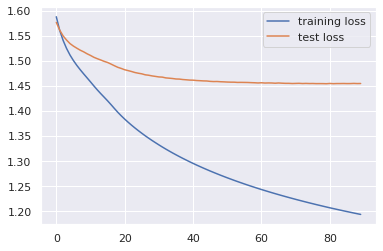

In [86]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns


sns.set()
x = np.arange(len(training_losses))
plt.plot(x, training_losses, label = 'training loss')
plt.plot(x, test_losses, label = 'test loss')
plt.legend()

In [97]:
print(confusion_matrix[89])

tensor([[279., 289., 211.,  29., 153.],
        [137., 999., 300.,  92., 360.],
        [137., 398., 538.,  53., 159.],
        [ 62., 242.,  89., 290., 160.],
        [ 90., 451., 180.,  68., 698.]])


In [102]:
diagnal = 0

ep =89
for i in range(5):
    for j in range(5):
        distance+= confusion_matrix[ep-1][i][j]*abs(i-j)
        if i == j:
            diagnal += confusion_matrix[ep-1][i][j]
print("diag: ",diagnal)

diag:  tensor(2807.)


# Comparing this 2807 to the BERT: 3167

# Cons:
1. Not as accurate

# Pros:
1. Light weighted (the size of pt file is 401kb v.s BERT 438mb)
2. Fast train
3. Does not consider relationship between words, so we can retrieve Keywords.

In [87]:
# kept = ['problems with friends', 'ongoing depression','breakup with partner', 'academic pressure', 'job crisis' ]

In [11]:
featureExtractor.load_state_dict(torch.load("5_emb.pt"))

<All keys matched successfully>

# Test the Model

In [37]:
example1 = "How are you doing today? It is not very good. How does it feels like? I think we can think. We need to talk."
words1 = example1.split(" ")
seq1 = []
for word in words1:
    if word in corpora.index_word:
        seq1.append(corpora.word_index[word])
    else:
        seq1.append(0)
seq1 = torch.tensor([seq1]).cuda(0)
z = featureExtractor.forward(seq1)
d = torch.softmax(z,dim=-1)
print("Example: ", example1, "\nsq: ", seq1, "\nprediction: ", d)

Example:  How are you doing today? It is not very good. How does it feels like? I think we can think. We need to talk. 
sq:  tensor([[   15,    16,    60,   410,   145,    63,   189,   223,   549,  1673,
            15,    13,    12,  4100, 10432,     1,    70,   200,    91,  1805,
           981,   165,    28,  5042]], device='cuda:0') 
prediction:  tensor([[0.0459, 0.7510, 0.1518, 0.0026, 0.0488]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


In [89]:
embeddings = featureExtractor.embedding(torch.tensor(list(range(20000))).cuda(0))
NUM = 100

# Top 100 words for Probelm with Friends

In [90]:
problem_with_friends = torch.torch.topk(embeddings[:,0], NUM).indices
for i in range(NUM):
    print(corpora.index_word[problem_with_friends[i]])

friendship
friend.
friendship.
friends

friend
anime
friend?
friend,
friends
friendships
lie
conflict
friendship?
invite
hang
friends.
building
dear.
having?

friendships.
fight

behavior
condition.
back.

We've
invited
empty
from.

.

O
them?
misunderstanding.
Trump
friends.

judge
nephew
ignoring
neighbors
friend

shame
Great,
upset
steps
raising
loose
acting
Corona
group
change.
borrowed
emotional
count
army
interests
seriously.
!
dealt
hurt
Friday.
ya.
trust?
contracted
refuse
disgust
Canada
sweet.
awkward.
made.
(so-called)
asking
pre
parties
asking!
person?
offended
divorces
bubble
personality.
tough.

message.
hmm
behaved
stated
Thanks!

she's
inappropriate,
recall
beating
extreme
advantage
topic
fine.

LGBT
typed?

Anime
clubs
before?

snowing
arrested
hours.



# Top 100 words for Ongoing Depression

In [91]:
ongoing_depression = torch.torch.topk(embeddings[:,1], NUM).indices
for i in range(NUM):
    print(corpora.index_word[ongoing_depression[i]])

death
depression.
depressed.
depression,
store
die
Medium
vitamin
dad
Got
dog?
start?

celebration
fiancée
family?

mask,
rut.
black
died
cancer.
son's
depression?
relatively
cycle
Depression
recognize
church
ambulance
coast
planner
insight
demands
granddaughter
sexual
everything?
spirits
kitchen
mindfulness
movies.
workouts
rare
sad,
mortality
trips
depression

Florida
bother
dwelling
m
discuss?
much

in

quarantine.
hotel
attacks
coughing
rut
battle
beach
husband
sport
consider

words

symptoms.
selfish
dear
See
Poor
accident
teh
picturing
passing
VERY
funk
n
loss?
long

minimal
wisdom
chilly
teenager
fan
hotels
Recently
employment.
job..
boyfriends
place

celebrate
pets.
evictions
paranoid
signing
teeth
mother
shy.
positive,
d
lake
husband's


# Top 100 words for Breakup with Partner

In [92]:
breakup_with_partner = torch.torch.topk(embeddings[:,2], NUM).indices
for i in range(NUM):
    print(corpora.index_word[breakup_with_partner[i]])

breakup
ex
breakup.
breakups
partner
breakup?
Doug
Breakups
dumped
split
divorce
cheat
relationship
relationship?
wasted
relationship,
broke
suitation
together?
idea?
him?
breakup,
love

marriage
closure.
break
cheated
unfaithful
awkward
broken
surprise
relationship?

problem?
occurrence
sudden.
men
kindness.
relationships
Keri.
instead.
both.
married
hurt.
description
problematic
blew
laughing
comic
met
too


Tinder
text,
engaged
but,
denies
partner.
partner?
relationship.
porn
man
dump
together
connected
happened

fight.
LOT
want.
Here's
deserved
smart,
that!

marry
gym.
x
group,
marriage.
ex.
memories
emotions
there?
there's
hobby,
anniversary
u

pretending
Crossfit
intimate
reminded
woman.
relationships.
helped.

girlfriend
breaking
damn
neglect
enjoy?

cheat

detail
Rob,
guy.


# Top 100 words for Academic Pressure

In [93]:
academic_pressure = torch.torch.topk(embeddings[:,3], NUM).indices
for i in range(NUM):
    print(corpora.index_word[academic_pressure[i]])

study
academic
studying
semester
exam
exams
grade
professor
class
grades
school
professors
finals
test
fail
school,
school?
study.
advisor
parents
class.
study?
classes
progress
class,
campus
renewed
compare
failing
math
test.
me?

approach
assignment
presentation
exams.
school.

pass
schedule
programs
students
pressures
college
exams?
reward
library
stress?
major?
overdo
semester

program
visa
university
failure
studying.
explain
grades.
classes,
teacher
loan
biking
procrastinating
tutors
studies
app
debt
economics
learning
activity,
required
Exams
poorly
schooling
courses,
majors
deadlines
:/
stage.
graduate.
covid.

rattle
rest

hope.

amazing,
teacher?
almost
done

season.
study,
smart
managing
classmates
credits
say.

understanding
form
experience?

telling
speaking

studies?


# Top 100 words for Job Crisis

In [94]:
job_crisis = torch.torch.topk(embeddings[:,4], NUM).indices
for i in range(NUM):
    print(corpora.index_word[job_crisis[i]])

boss
boss.
HR
supervisor
jobs.
job?

co-worker
unemployment
job.
job

gig
job
manager
laid
job?
opportunities
typing
warehouse
business
colleagues
resume
income.
money

reduce
company
Uber
degrees
employee
positions
Well.
jobs
resume

upper
angle
HR.
Currently
expenses
director
friend!
jobs?
Human
uber
boat.
coworkers
co-workers
degree

update
employment
ran
plan?
Job
staffs
bananas
stores
hiring.
items
burned
boss,
far!
anxiety,
resume,
jobs.

approaching
have,
submitted
ya,
manager?
Me
expenses.
motivational
dunno.
work?

industry
channel.
step.
walked
jobs,
encouraged
2021!
promising
salary
relax?
January
offices
presents
Hey,
cool,
jobs?

releasing
principal
cold.
modern
field.
remind
January.
Money
workplace.
ya!
unknowns.
HR?
